#  Epileptic Seizure Detection

In [1]:
#essai

In [1]:
# imports
import pandas as pd
import numpy as np

from string import ascii_letters
import seaborn as sns

import glob

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import interp
from scipy.fftpack import fft
from scipy.signal import periodogram, welch
from scipy.integrate import cumtrapz

import itertools
from itertools import cycle

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb
#import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

C:\Users\gcorda\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Question 1: Database construction

<b>We have discrete time measurements so we are going to create chunks to apply discrete Fourier transform on and access to the spectral space. Each recording has 614 401 observations, we could separate each one in chunks containing 1 327 observations. 

Once our dataset is ready, we need to drop the 'label' column containing our target and store it into a list. Then we can use the sklearn <i>train_test_split</i> function in order to create our training and validation sets. 
We will take 66% of the data to train our model and 34% to evaluate it.

In [2]:
# Creating one dataset per recording
rec_1 = pd.read_csv('Data/rec_1.csv')
rec_2 = pd.read_csv('Data/rec_2.csv')
rec_3 = pd.read_csv('Data/rec_3.csv')
rec_4 = pd.read_csv('Data/rec_4.csv')
rec_15 = pd.read_csv('Data/rec_15.csv')
rec_16 = pd.read_csv('Data/rec_16.csv')
rec_17 = pd.read_csv('Data/rec_17.csv')
rec_18 = pd.read_csv('Data/rec_18.csv')

In [3]:
# Discovering data
rec_1.shape

(614401, 6)

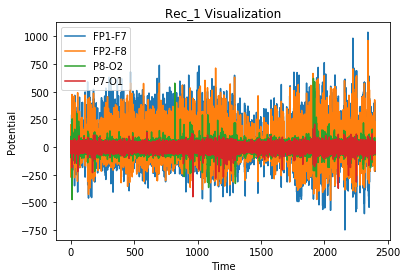

In [4]:
columns = ['FP1-F7','FP2-F8','P8-O2','P7-O1']
for col in columns:
    plt.plot(rec_1['Unnamed: 0'],rec_1[col], label = col)
plt.legend(fontsize = 10)
plt.xlabel('Time')
plt.ylabel('Potential')
plt.title("Rec_1 Visualization")
plt.show()

<b> A simple visualization allows us to detect when the patient has a seizure.

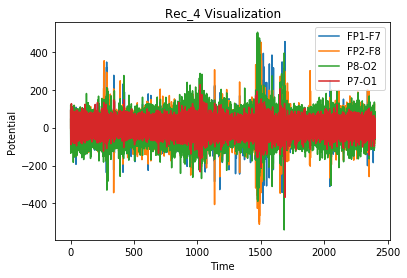

In [5]:
columns = ['FP1-F7','FP2-F8','P8-O2','P7-O1']
for col in columns:
    plt.plot(rec_4['Unnamed: 0'],rec_4[col], label = col)
plt.legend(fontsize = 10)
plt.xlabel('Time')
plt.ylabel('Potential')
plt.title("Rec_4 Visualization")
plt.show()

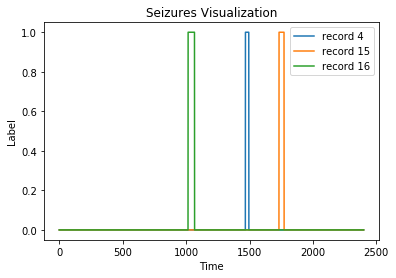

In [6]:
recordings = {'record 4' : rec_4, 'record 15' : rec_15, 'record 16' : rec_16}
indices = [4,15,16]
for key,rec in recordings.items() :
    plt.plot(rec['Unnamed: 0'],rec['label'], label=key)
plt.legend(fontsize = 10)
plt.xlabel('Time')
plt.ylabel('Label')
plt.title("Seizures Visualization")
plt.show()

In [7]:
path ='Data' # use your path
all_Files = glob.glob(path + "/*.csv")

In [8]:
all_Files

['Data\\rec_1.csv',
 'Data\\rec_15.csv',
 'Data\\rec_16.csv',
 'Data\\rec_17.csv',
 'Data\\rec_18.csv',
 'Data\\rec_2.csv',
 'Data\\rec_3.csv',
 'Data\\rec_4.csv']

In [9]:
# Creating a dataframe containing all recordings
df = pd.DataFrame()
file_List = []

for file in all_Files:
    df = pd.read_csv(file)
    file_List.append(df)
df = pd.concat(file_List)

In [10]:
df

,Unnamed: 0,FP1-F7,FP2-F8,P8-O2,P7-O1,label
0,0.000000,-145.934066,-267.838828,74.822955,-33.015873,0
1,0.003906,0.195360,0.195360,0.195360,0.195360,0
2,0.007812,0.195360,0.195360,-0.195360,0.195360,0
3,0.011719,0.195360,-0.586081,-2.148962,0.586081,0
4,0.015625,0.195360,-0.195360,0.976801,-0.195360,0
5,0.019531,0.976801,4.493284,10.744811,-1.367521,0
6,0.023438,0.586081,4.493284,8.400488,-0.195360,0
7,0.027344,-1.758242,-5.665446,-10.354090,1.758242,0
8,0.031250,-1.367521,-7.619048,-12.698413,0.976801,0
9,0.035156,2.930403,7.619048,12.307692,-1.367521,0


In [11]:
list(df.columns)

['Unnamed: 0', 'FP1-F7', 'FP2-F8', 'P8-O2', 'P7-O1', 'label']

In [12]:
df.rename_axis({'Unnamed: 0' : 'Time'}, axis=1, inplace=True)

In [13]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [14]:
df.shape

(4915208, 6)

In [15]:
df['label'].value_counts() #Checking how imbalanced the dataset is

0    4861956
1      53252
Name: label, dtype: int64

<b> With more time a label 1 data oversampling would have been useful to obtain better results. Methods such as Synthetic Minority Oversampling MEthod (SMOTE) could be apply easily on this dataset to create new instances of label 1.

<b> Let's create chunks to split our dataset. 1327 is divider of 614401.

In [16]:
def chunk_creator (df, chunkSize = 1327): 
    list_Df = []
    numberChunks = len(df) // chunkSize
    for i in range(numberChunks):
        list_Df.append(df[i*chunkSize:(i+1)*chunkSize])
    return list_Df

In [17]:
df_New = chunk_creator(df)
df_New[0].head(5)

,Time,FP1-F7,FP2-F8,P8-O2,P7-O1,label
0,0.000000,-145.934066,-267.838828,74.822955,-33.015873,0
1,0.003906,0.195360,0.195360,0.195360,0.195360,0
2,0.007812,0.195360,0.195360,-0.195360,0.195360,0
3,0.011719,0.195360,-0.586081,-2.148962,0.586081,0
4,0.015625,0.195360,-0.195360,0.976801,-0.195360,0


##  Question 2: Feature extraction

### 1st Method : Periodogram

<b> The <i>periodogram</i> function allows us to compute an estimation of PSD. Each recording has 4 different signals records and we need to compute PSD on 5 different frequency bands which will lead us to 20 features on our final dataset. We will use to do so the periodogram function from scipy module to go into the spectral space, then we will compute the PSD integrating the square of the output on the five given frequency bands.

In [18]:
T = rec_1['Unnamed: 0'][2] - rec_1['Unnamed: 0'][1] #Computing sampling frequence
fs= 1/T

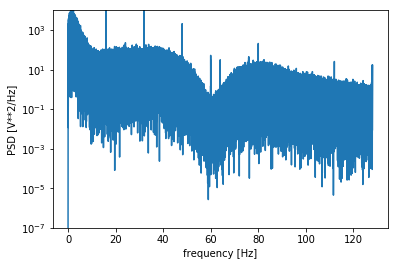

In [19]:
f, Pxx_den = scipy.signal.periodogram(rec_1['FP1-F7'], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e4])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

The compute_periodogram function create one dataset per csv file to catch spectral information.

In [20]:
def compute_periodogram (data_rec, fs=fs):
    
        data = pd.DataFrame()
        data['Freq'] = scipy.signal.periodogram(data_rec['FP1-F7'],fs=fs)[0]

        for col in ['FP1-F7', 'FP2-F8', 'P8-O2', 'P7-O1'] :
            data[col] = scipy.signal.periodogram(data_rec['FP1-F7'],fs=fs)[1]
        return data

In [21]:
for file in df_New :
        compute_periodogram(file)

To integrate over the frequency bands imposed we have to create the two following functions.

In [22]:
def find_min_freq(L, f_min):
    for f in L :
        if f >= f_min :
            return f
            break

In [23]:
def find_max_freq(L, f_max):
    for i in range(len(L)) :
        while L[i] <= f_max :
            i+=1
        return L[i-1]

def compute_PSD (f_min, f_max):
    f_ini = find_min_freq(L=rec_1_PSD['Freq'], f_min=f_min)
    f_fin = find_max_freq(L=rec_1_PSD['Freq'], f_max=f_max)
    scipy.cumtrapz(rec_1_PSD['FP2-F8_PSD'], rec)

I did not succeed to finish this question.

### 2nd Method : Welch Method's

In [24]:
f, Pxx_den = welch(rec_1['FP1-F7'])

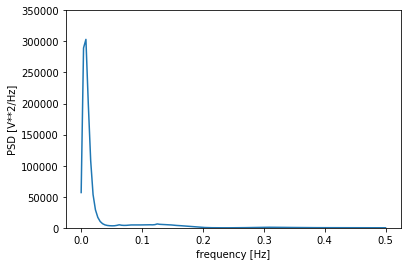

In [25]:
#plt.semilogy(f, Pxx_den)
plt.plot(f, Pxx_den)
plt.ylim([0, 350000])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

An alternative to the periodogram function could be to compute PSD thanks to the Welch method.

### 3rd method : Wavelets

Then we also could have been decomposing our temporal signals with wavelets.

### Other method or approach

<b> After the feature extraction we are able to classify signals. We could have visualize data to have more information. We also could have created new variables or reduce dimension. We can compute correlation matrix to see dependencies among our features for instance.

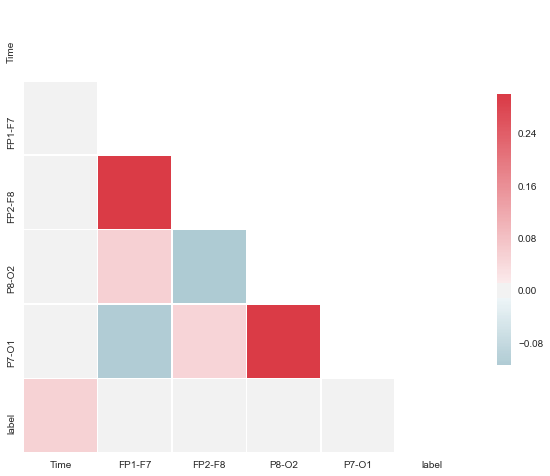

In [26]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Question 3: Classification task

<b>If observations were linearly separable a SVM would have been accurate enough. However I did not compute spectral features so with the million of observations I have in my training set a SVM would take to much time to fit. 

In our particular case of EEG analysis the best option would have been to use Deep Learning methods, in particular <u>Recurrent Neural Networks</u> like LSTM to detect sequences in time. Indeed using algorithms with memory is more efficient with time dependent data.

<i> I did not succeed to extract correctly our new features so I will do the classification task only using raw data to obtain a result. </i>

### Creating training and validation sets

In [27]:
y = df['label']
X = df.copy()
X.drop('label', axis=1, inplace=True)
#Splitting data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state = 42, stratify=y)

In [42]:
X_train.shape

(3293189, 5)

In [28]:
y_val.value_counts()

0    1604446
1      17573
Name: label, dtype: int64

<b>Our two classes are quite imbalanced, label 1 observations are only representing 1% of our dataset. If we use a regular accuracy function, a classifier would assign a lot of observations from the minority label (label 1) into the majority label (label 0) in order to increase its score. To avoid this problem we will visualize the efficiency of our classifier by plotting a <u><i>ROC curve</i></u>. To catch more information, we will compute and plot the associated <u><i>confusion matrix</i></u>.

In [37]:
# Compute ROC curve and ROC area then plot it
def plot_ROC_Curve (y_val, y_score, model) : 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic' + " - " + model)
    plt.legend(loc="lower right")
    plt.show()

In [30]:
def plot_confusion_matrix(cm, classes, model, cmap=plt.cm.Blues):

    print('Confusion matrix')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix - " + model)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

class_names={'Label 0', 'Label 1'}

<b> Let's try a Random Forest classifier.

### Random Forest

In [31]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_score = rfc.predict(X_val)

#### ROC Curve

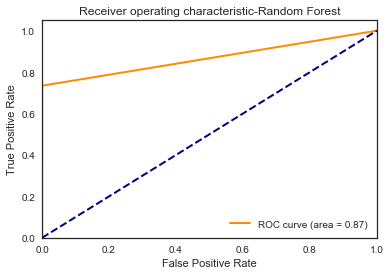

In [32]:
plot_ROC_Curve (y_val, y_score, model="Random Forest")

#### Confusion Matrix

Confusion matrix
[[1603912     534]
 [   4665   12908]]


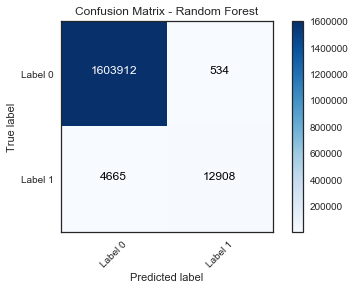

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_score)
np.set_printoptions(precision=2)


# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, model="Random Forest")

Random Forest gives a good accuracy but takes too much time to compute, let's try another tree algorithm.

### XGBoost

In [38]:
# Trying to correct the dataset imbalance fine tuning xgboost 
scale_pos_weight = int(len(df['label']) / df['label'].sum())

In [39]:
clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)
y_score = clf.predict(X_val)

#### ROC Curve

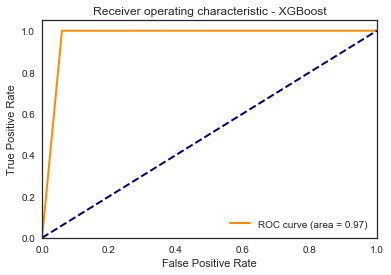

In [40]:
plot_ROC_Curve(y_val, y_score, model="XGBoost")

#### Confusion Matrix

Confusion matrix
[[1509124   95322]
 [      3   17570]]


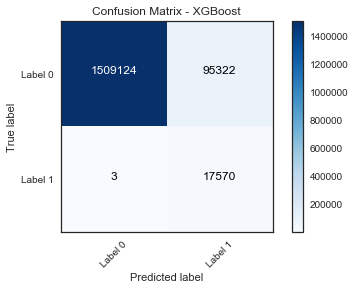

In [41]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_score)
np.set_printoptions(precision=2)


# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, model="XGBoost")

<b> As we can see it above, our gradient boosting classifier is very accurate when fine tuned. Only 3 label 1 observations are misclassified against more than 10 000 misclassified when not tuned. 

## Question 4: Going further

For epilepsy seizure detection an approach using deep learning algorithms could have given even better results.
Indeed, the use of neural networks could have led us to discover new features and therefore to deepen the work asked
on question 2.

As we mentioned above, more visualizations would also have allowed us to have complete information about the data.
Then, still using neural networks, an LSTM networks (Long Short-Term Memory) seems more suitable here than the XGBoost or Random Forest I used in the sense that it keeps in memory sequences that are given to it as input.
Therefore he will know that a crisis breaks out a few moments before it begins strongly and perhaps becomes dangerous.


To conclude, after having tested and fine tuned the classifiers with the greatest precision, we will be able to create a function allowing to attribute a weight to each classifier according to the quality of its predictions and thus make a vote for each observation between the classifiers what would give more accurate results.

# Understanding machine learning algorithms

Nowadays it is most of the time complex models that give the best results such as ensemble or deep learning. To create a balance between performance and interpretability various methods have recently been proposed.

I read that a new framework was out for interpreting predictions. It is called <b>SHapley Additive exPlanations</b> (SHAP). As I read it in the documentation it assigns each feature an importance value for a particular prediction. Therefore we have the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Thus our models have better consistency with human intuition than previous approaches. 

An other solution could be to use the <b>Local Interpretable Model-Agnostic Explanations</b> (LIME) library. The idea behind this package is to <u>approximate a complex model by simple models <b>locally</b></u>. We can thus reconstruct step by step with the help of multiple simple models the black-box reasoning.